In [1]:
import pyautogui as gui
import cv2
import time
import pytesseract
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
class Airplane():
    def __init__(self, flightnum = None, model = None, current_height = 0, target_height = 0, speed = 0, position = (0,0), heading = "SPL"):
        self.flightnum = flightnum
        self.info = ""
        self.model = model
        self.current_height = current_height
        self.target_height = target_height
        self.speed = speed
        self.heading = heading
        self.position = position
        
    def __repr__(self):
        return "<Airplane flightnum:%s position:%s>" % (self.flightnum, self.position)
        
    def __str__(self):
        return "%s%s, screen position: %s, passing flight level %d to flight level %d, speed %d knots, %s." % (self.flightnum, self.model, str(self.position), self.current_height, self.target_height, self.speed, self.heading)

In [3]:
def calibrate():
    time.sleep(5)
    calibrate_img = cv2.cvtColor(np.array(gui.screenshot()), cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(calibrate_img, cv2.COLOR_BGR2GRAY)
#     print(gray[300, 360], gray[300, 361])
    screen_idx = 0
    top_idx = 0
    bot_idx = 0
    info_idx = 0
    black_code = 0
    
    for i in range(gray.shape[1]):
        if gray[300, i] == black_code:
            screen_idx = i
            print(i)
            break
        
    for i in range(gray.shape[0]):
        if gray[i, 800] == black_code:
            top_idx = i
            print(i)
            break
        
    for i in reversed(range(gray.shape[0])):
        if gray[i, 800] == black_code:
            bot_idx = i
            print(i)
            break

    
    # plt.imshow(grayscreen, cmap='gray', vmin=0, vmax=255)
    # plt.imsave("grayscreen.png", grayscreen, cmap='gray')
    grayscreen = gray[top_idx:bot_idx, screen_idx:]
    threshold = 1400
    for i in reversed(range(grayscreen.shape[0])):
        count = np.count_nonzero(grayscreen[i] == black_code)
        if count < threshold:
            info_idx = i
            print(i)
            break;
    
    print("screen_idx=", screen_idx)
    print("top_idx=", top_idx)
    print("bot_idx=", bot_idx)
    print("info_idx=", info_idx)
    

In [4]:
def ocr(img):
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
    text = pytesseract.image_to_string(img, lang='eng')
    return text

In [12]:
def qualify(x, y, top_idx=32, bot_idx=1029, screen_idx=360, info_idx=976):
    if y >= top_idx and y <= bot_idx and x >= screen_idx:
        return True
    else:
        return False

In [13]:
## refactor

def remove_dq_pts(pts, threshold):
    elements = []
    for (x, y) in pts:
        if qualify(x, y):
            for ele in elements:
                if ((x-ele[0])**2 + (y-ele[1])**2) < threshold**2:
                    break
            else:
                elements.append((x,y))
    
    return elements

In [14]:
def find_plane_pts(template, threshold=0.8, method=cv2.TM_CCORR_NORMED):
    # Apply template Matching
    img = cv2.cvtColor(np.array(gui.screenshot()), cv2.COLOR_RGB2BGR)
    resultimg = img.copy()
    res = cv2.matchTemplate(resultimg, template, method)

    location = np.where(res >= threshold)
#     print(location)
    pts = zip(*location[::-1])
    plane_pts = remove_dq_pts(pts, min(template.shape[0], template.shape[1]))
    
    color = (0, 0, 255)
    for pt in plane_pts:
#         print("zz", pt)
        cv2.rectangle(resultimg, (pt[0], pt[1]), (pt[0]+15, pt[1]+15), color, 2)
    
    plt.imsave("result.png", resultimg)
    return plane_pts

In [15]:
def get_plane_info(img, top_idx=32, bot_idx=1029, screen_idx=360, info_idx=976, line_top_dis=-18, line_bot_dis=+7, id=0):
    screen = img[top_idx:bot_idx, screen_idx:, :]
    line = screen[info_idx+line_top_dis:info_idx+line_bot_dis]
    plt.imsave(str(id)+"line.png", line)
    text = ocr(line).strip().split('.')[0]
    return text

In [16]:
def update_planes_info(plane_pts):
    airplanes = []
    for pt in plane_pts:
        print(pt)
        gui.click(x=pt[0], y=pt[1])
        info_img = cv2.cvtColor(np.array(gui.screenshot()), cv2.COLOR_RGB2BGR)
        info = get_plane_info(info_img, id=plane_pts.index(pt))
        airplane = Airplane(position=pt)
        airplane.info = info
        print(info)        
        try:
            airplane.flightnum = info.split(',')[0].split()[0]
            airplane.heading = int(info.split(',')[3].split("heading")[1])
        except:
            None
        airplanes.append(airplane)
        
    
    print(airplanes)
    return airplanes

In [17]:
def calculate_heading(plane, target):
    dx = target[0] - plane[0]
    dy = target[1] - plane[1]

    angle = math.atan2(dy, dx)
    angle = int(angle * 180/math.pi)
    if angle <= 0:
        angle += 360
    heading = angle+90
    if heading > 360:
        heading -= 360
        
    print(heading)
    return heading

In [37]:
def distance(plane, target):
    dx = target[0] - plane[0]
    dy = target[1] - plane[1]

    dist = math.sqrt(dx**2 + dy**2)
        
    print(dist)
    return dist

In [38]:
## Main
button_size = 73
offset = 35
button_de_alt = (15+offset, 464+offset)
button_de_speed = (15+offset, 566+offset)
button_de_head = (15+offset, 668+offset)
button_in_alt = (279+offset, 464+offset)
button_de_speed = (279+offset, 566+offset)
button_de_head = (279+offset, 668+offset)
button_ils = (15+offset, 768+offset)
button_ok = (15+offset, 868+offset)
target = (750, 700)

time.sleep(1)
gui.hotkey('alt', 'tab')
time.sleep(2)
gui.click(target)

bonding_box = cv2.imread('marker.png')
plane_pts = find_plane_pts(bonding_box)
print(plane_pts)

airplanes = update_planes_info(plane_pts)
control_plane = airplanes[0]
print("ControlPlane:", control_plane)


## control
instruction_alt = 20
interval = 0.25
gui.click(control_plane.position)
gui.press('space')
time.sleep(interval)
gui.press('a')
time.sleep(interval)
for s in str(instruction_alt):
    gui.press(s)
    time.sleep(interval)
gui.click(button_ok)

instruction_head = calculate_heading(control_plane.position, target)
gui.click(control_plane.position)
gui.press('space')
time.sleep(interval)
gui.press('h')
time.sleep(interval)
for s in str(instruction_head):
    gui.press(s)
    time.sleep(interval)
gui.click(button_ok)



round = 5
for i in range(round):
    plane_pts = find_plane_pts(bonding_box)
    airplanes = update_planes_info(plane_pts)
    
    control = False
    for plane in airplanes:
        if plane.flightnum == control_plane.flightnum:
            control_plane.position = plane.position
            control_plane.heading = plane.heading
            control = True
            
    
    if control:
        print("!!!!!!!!!Update control plane!!!!!!!!")
        print("ControlPlane:", control_plane)
    else:
        print("!!!!!!!!!Control Plane lost!!!!!!!!")
        control_plane = airplanes[0]
        
    
    ## Control
    instruction_alt = 20
    interval = 0.25
    gui.click(control_plane.position)
    gui.press('space')
    time.sleep(interval)
    gui.press('a')
    time.sleep(interval)
    for s in str(instruction_alt):
        gui.press(s)
        time.sleep(interval)
    gui.click(button_ok)
    
    
    if distance(plane.position, target) > 30:
        instruction_head = calculate_heading(control_plane.position, target)
        gui.click(control_plane.position)
        gui.press('space')
        time.sleep(0.25)
        gui.press('h')
        time.sleep(0.25)
        for s in str(instruction_head):
            gui.press(s)
            time.sleep(0.25)
        gui.click(button_ok)
    else:
        instruction_head = 80
        gui.click(control_plane.position)
        gui.press('space')
        time.sleep(0.25)
        gui.press('h')
        time.sleep(0.25)
        for s in str(instruction_head):
            gui.press(s)
            time.sleep(0.25)
        gui.click(button_ok)
        gui.click(button_ils)
    
    time.sleep(5)

# gui.press('esc')
# gui.hotkey('alt', 'tab')

[(731, 318), (1165, 430), (1200, 579), (740, 714)]
(731, 318)
KLM913 (B772), passing FL62 descending to 2000 feet, speed 250 knots, heading 173
(1165, 430)
KLM11 (E190), maintaining FL70, speed 220 knots, heading 022
(1200, 579)
KLM1521 (A333), maintaining FL70, speed 220 knots, heading 120
(740, 714)
KLM93U (B772), maintaining 2000 feet, speed 220 knots, heading 246
[<Airplane flightnum:KLM913 position:(731, 318)>, <Airplane flightnum:KLM11 position:(1165, 430)>, <Airplane flightnum:KLM1521 position:(1200, 579)>, <Airplane flightnum:KLM93U position:(740, 714)>]
ControlPlane: KLM913None, screen position: (731, 318), passing flight level 0 to flight level 0, speed 0 knots, 173.
177
(732, 325)
KLM913 (B772), passing FL61 descending to 2000 feet, speed 250 knots, turning to heading 177
(1167, 424)
KLM11 (E190), maintaining FL70, speed 220 knots, heading 022
(1206, 582)
KLM1521 (A333), maintaining FL70, speed 220 knots, heading 120
(734, 716)
KLM93U (B772), maintaining 2000 feet, speed 220

IndexError: list index out of range

In [ ]:
airplanes

In [ ]:
button_size = 73
button_de_alt = (15, 464) 
button_de_speed = (15, 464+102)
button_de_head = (15, 464+204)
button_in_alt = (279, 464)
button_de_speed = (279, 464+102)
button_de_head = (279, 464+204)
ILS = (15, 464+300)

click = cv2.imread('click.png')
resultimg = click.copy()
color = (0, 0, 255)
cv2.rectangle(resultimg, ILS, (ILS[0]+button_size, ILS[1]+button_size), color, 5)
plt.imshow(resultimg)
plt.imsave("button_ils.png", resultimg)

In [ ]:
a = cv2.imread('lineex.png')
plt.imshow(a)
ocr(a)

In [ ]:
calculate_heading((1461, 402), (700, 750))

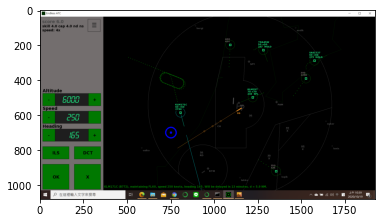

In [34]:
palse = cv2.imread("half.png")
runway = palse[750:800, 700:1200]
plt.imshow(runway)
target = (750, 700)
size = 3
radius = 30
color = (0, 0, 255)
cv2.rectangle(palse, (target[0]-size, target[1]-size), (target[0]+size, target[1]+size), color, 5)
cv2.circle(palse, target, radius, color, 5)
plt.imshow(palse)
plt.imsave("target_with_c.png", palse)

In [ ]:
time.sleep(5)
gui.screenshot("close.png")

In [ ]:
# screen_idx= 366
# top_idx= 32
# bot_idx= 1029
# info_idx= 976
# normal = cv2.imread("click.png")
# screen = normal[top_idx:bot_idx, screen_idx:, :]
# linee = screen[info_idx-17:info_idx+7]
# plt.imshow(linee)
# plt.imsave("linee.png", linee)
# ocr(linee)

In [ ]:
# infoimg = screen[info_idx-15:info_idx+5]
# # plt.imshow(infoimg)
# text = ocr(infoimg)
# print(text)

# info = text.split(',')
# flightnum = info[0].split()[0]
# model = info[0].split()[1]
# current_height = int(info[1].split()[3])
# target_height = int(info[1].split()[8])
# speed = int(info[2].split()[1])
# heading = info[3]
# plane_find = Airplane(flightnum, model, current_height, target_height, speed, heading=heading)
# print(plane_find)